# Vault Entity Audit


## Alogrithm

- Query all auth methods and store in lookup table.
    - Path
    - Type
    - Accessor (PK)
- Lookup all client activity via export API
    - ClientID
    - Timestamp
    - auth mount accessor
- Perform Look-up on client-id       

## Set Environment

In [14]:
import os
import requests
import json
import datetime
import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Set my environment
# os.environ['VAULT_ADDR'] =  'http://127.0.0.1:8200'
# os.environ['VAULT_TOKEN'] = 'hvs.4O3Nh0I75YUMdZZS99cJt8xk'
# os.environ['VAULT_TOKEN'] = 'hvs.CAESIPA6tTKqzn_UiXnRRmstt7nuhJYadG_ed7itSZbBo-pyGh4KHGh2cy54MTlhZmt0cGFnOHF0bjBCQVRVdVhFcHE'

In [10]:
# Environment Variables Should be set ahead of time
token = os.getenv('VAULT_TOKEN')
base_url = os.getenv('VAULT_ADDR')

## Build Report

In [11]:

# Build Auth-Lookup Table
auth_url = f"{base_url}/v1/sys/auth"
headers = {
    "X-Vault-Token": token,
    "accept": "*/*"
}

auth_lookup = {}
response = requests.get(auth_url, headers=headers)
data = response.json()
for path, auth_info in data.items():
    if isinstance(auth_info, dict) and 'accessor' in auth_info and 'type' in auth_info:
        accessor = auth_info['accessor']
        auth_type = auth_info['type']
        auth_lookup[accessor] = {"path": path, "type": auth_type}

# headers = {
#     "X-Vault-Token": token
# }

url = f'{base_url}/v1/sys/internal/counters/activity/export'
response = requests.get(url, headers=headers)
lines = response.text.strip().split("\n")

client_data= []
for line in lines:
    try: 
        data = json.loads(line)
        timestamp = data.get('timestamp', 0)
        human_ts = datetime.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        # print (human_ts)
        # data['timestamp'] = human_ts
        data['date'] = human_ts
        data['auth_type'] = auth_lookup[data.get('mount_accessor')]['type']
        data['auth_path'] = auth_lookup[data.get('mount_accessor')]['path']
        client_data.append(data)
    except json.JSONDecodeError as e:
        print (f"Error decoding JSON: {e}")

# Add Entity Details
entity_url_template = f"{base_url}/v1/identity/entity/id/{{client_id}}"

for client in client_data:
    print (client)
    client_id = client['client_id']
    mount_accessor = client['mount_accessor']
    entity_url = entity_url_template.format(client_id=client_id)
    isNonEntity = client.get('non_entity', False)
    
    if isNonEntity:
        print ("non-entity")
        client['name'] = "Non-Entity"
    else:
        print ("entity")
        entity_response = requests.get(entity_url, headers=headers)
        entity_data = entity_response.json()
        for alias in entity_data.get('data',{}).get('aliases',[]):
            if alias.get('mount_accessor') == mount_accessor:
                client['name'] = alias.get('name')
                break

pprint.pprint(client_data, indent=4)


{'client_id': 'hLg1a3Y6NnyKJpMBfSb4aY+a6eQSM+oxJ18OCWPFb9U=', 'namespace_id': 'root', 'timestamp': 1677446143, 'non_entity': True, 'mount_accessor': 'auth_token_02aa59c9', 'date': '2023-02-26 21:15:43', 'auth_type': 'token', 'auth_path': 'token/'}
non-entity
{'client_id': '00f6d8b7-8be0-7afb-ef49-96799166d59b', 'namespace_id': 'root', 'timestamp': 1677696353, 'mount_accessor': 'auth_github_d77548a3', 'date': '2023-03-01 18:45:53', 'auth_type': 'github', 'auth_path': 'github/'}
entity
[   {   'auth_path': 'token/',
        'auth_type': 'token',
        'client_id': 'hLg1a3Y6NnyKJpMBfSb4aY+a6eQSM+oxJ18OCWPFb9U=',
        'date': '2023-02-26 21:15:43',
        'mount_accessor': 'auth_token_02aa59c9',
        'name': 'Non-Entity',
        'namespace_id': 'root',
        'non_entity': True,
        'timestamp': 1677446143},
    {   'auth_path': 'github/',
        'auth_type': 'github',
        'client_id': '00f6d8b7-8be0-7afb-ef49-96799166d59b',
        'date': '2023-03-01 18:45:53',
      

## Generate CSV

In [15]:
# Rearrange columns order
reordered_fieldnames = [
    'timestamp', 'date', 'namespace_id', 'auth_type', 'auth_path', 'name', 'non_entity', 'mount_accessor', 'client_id'
]

# Output to CSV with reordered columns
csv_file = 'client_data.csv'

with open(csv_file, 'w', newline='') as f:
    csv_writer = csv.DictWriter(f, fieldnames=reordered_fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(client_data)


## Visualization

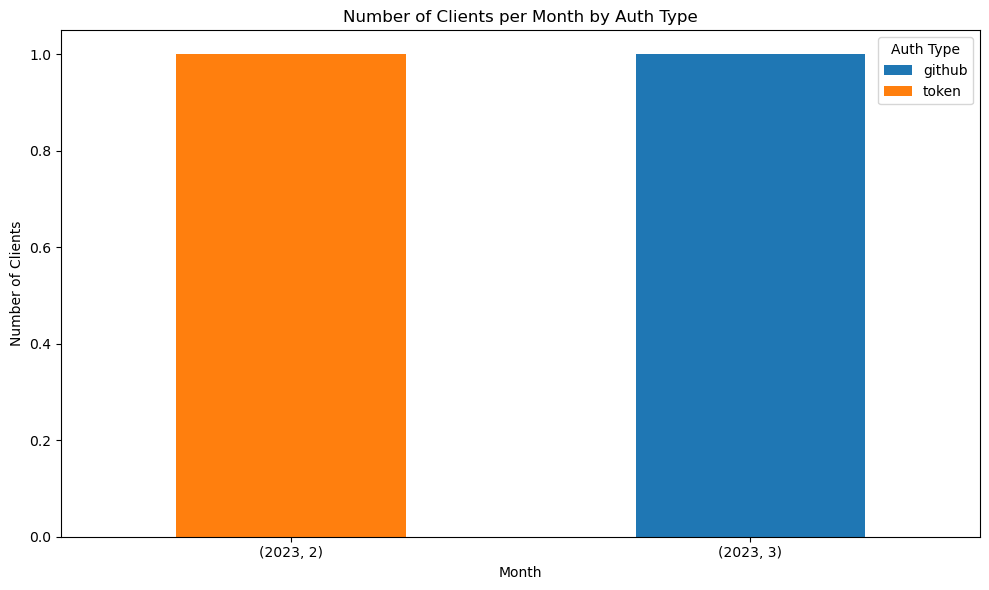

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert data to pandas DataFrame
df = pd.DataFrame(client_data)

# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Group data by month and auth_type
df_grouped = df.groupby([df['date'].dt.year, df['date'].dt.month, 'auth_type'])['client_id'].count().unstack(fill_value=0)

# Create a stacked bar chart
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Clients')
ax.set_title('Number of Clients per Month by Auth Type')
plt.xticks(rotation=0)
plt.legend(title='Auth Type')
plt.tight_layout()
plt.show()



